# Proyecto de analisys de embudo

# Descripcion de datos:

# Hoja Event

id	Identificador de evento

user_id	identificador unico de usuario

start_time	fecha y hora del evento

event_type	tipo de evento (valores: registration — registracion de usuario; tutorial_start — usuario empezo el tutorial; tutorial_finish — usuario termino el tutorial; level_choice — elecion de nivel de dificultad; pack_choice — elecion de preguntas)

tutorial_id	identificador del tutorial (solo en los eventos de tutorial)

selected_level  selecion de dificultd del tutorial

# Hoja Purchase
id	Identificador del evento

user_id	identificador unico de usuario

event_datetime	fecha y hora del evento

amount	suma de pago

# Objetivos del proyecto:

1. Determinar si completar el tutorial reduce el tiempo de completacion de otros etapas del juego y por cuanto.
2. Probar que la completar el tutorial influye en la compra, sin importar en que etapa se completo
3. Comprobar que tan transparente es el proceso de interaccion con el juego

Empezaremos con la importacion de datos y su procesamiento

In [1]:
# Importamos las bibliotecas
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

In [2]:
# Leemos el archivo Events.csv y mostramos informacion breve sobre los datos en ese archivo
events_df = pd.read_csv('7_4_Events.csv', sep=',')
events_df.info()
display(events_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252334 entries, 0 to 252333
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              252334 non-null  int64  
 1   event_type      252334 non-null  object 
 2   selected_level  31086 non-null   object 
 3   start_time      252334 non-null  object 
 4   tutorial_id     125103 non-null  float64
 5   user_id         252334 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 11.6+ MB


,id,event_type,selected_level,start_time,tutorial_id,user_id
0,28903,registration,NaN,2016-05-11T23:40:55,NaN,12583
1,28904,registration,NaN,2016-05-11T23:49:58,NaN,12584
2,28905,registration,NaN,2016-05-12T00:53:07,NaN,12585
3,28906,tutorial_start,NaN,2016-05-12T01:32:20,17562.0,12585
4,28907,tutorial_finish,NaN,2016-05-12T01:34:53,17562.0,12585


In [3]:
# Creamos un filtro para los usuarios registrados en el año 2018
mask2018 = (events_df['start_time'] < '2019-01-01') & (events_df['start_time'] >= '2018-01-01') & (events_df['event_type'] == 'registration')

# Dejamos solo a losmusuarios registrados en el año 2018
user_list = list(events_df[mask2018]['user_id'])
events_df = events_df[events_df['user_id'].isin(user_list)]

In [4]:
# Leemos el archivo Purchase.csv y mostramos informacion breve sobre los datos en ese archivo
purchase_df = pd.read_csv('7_4_Purchase.csv', sep=',')
purchase_df.info()
display(purchase_df.head())

# Dejamos solo a losmusuarios registrados en el año 2018
user_list = list(events_df[mask2018]['user_id'])
purchase_df = purchase_df[purchase_df['user_id'].isin(user_list)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956 entries, 0 to 5955
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              5956 non-null   int64 
 1   user_id         5956 non-null   int64 
 2   event_datetime  5956 non-null   object
 3   amount          5956 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 186.2+ KB


,id,user_id,event_datetime,amount
0,15674,12584,2016-05-12T10:34:16,100
1,15675,12985,2016-05-13T08:25:56,50
2,15676,12828,2016-05-13T16:33:46,50
3,15677,12598,2016-05-14T01:09:37,150
4,15678,13037,2016-05-14T01:24:46,100


C:\Users\ulama\AppData\Local\Temp\ipykernel_7068\864583225.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  user_list = list(events_df[mask2018]['user_id'])


In [ ]:
# Cambiamos los nombres de las columnas para juntar los 2 dataframes y mostramos las primeras 10 lineas del resultado
purchase_df['event_type'] = 'purchase'
events_df = events_df.rename(columns={"id": "event_id"})
purchase_df = purchase_df.rename(columns={"id": "purchase_id", "event_datetime": "start_time"})
events_df = pd.concat([events_df,purchase_df],sort=False)

# Cambiamos el tipo de datos en la columna start_time y omitimos los errores
events_df['start_time'] = pd.to_datetime(events_df['start_time'])
display(events_df.head(10))

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount,user_group
51405,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN,no_tutorial
51406,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN,tutorial_end
51407,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN,tutorial_end
51408,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN,tutorial_end
51409,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN,tutorial_end
51410,80313.0,registration,NaN,2018-01-01 14:08:40,NaN,27837,NaN,NaN,no_tutorial
51411,80314.0,registration,NaN,2018-01-01 14:42:58,NaN,27838,NaN,NaN,no_tutorial
51412,80315.0,tutorial_start,NaN,2018-01-01 14:54:40,31505.0,27836,NaN,NaN,tutorial_end
51413,80316.0,tutorial_start,NaN,2018-01-01 15:00:51,31506.0,27835,NaN,NaN,tutorial_end
51414,80317.0,tutorial_finish,NaN,2018-01-01 15:06:15,31506.0,27835,NaN,NaN,tutorial_end


Procesamiento terminado.

Ahora empezamos a comprobar la primera hipotesis. 
Si la completacion del tutorial reduce el tiempo de completacion de las etapas del juego.

In [ ]:
# Para empezar, necesitamos dividir a los usuarios en grupos de los que empezaron el tutorial, los que lo terminaron y los que no lo empezaron
# Para eso crearemos 2 variables tutorial_start_users y tutorial_end_users
tutorial_start_users = events_df[events_df['event_type'] == 'tutorial_start']['user_id'].unique()
tutorial_end_users = events_df[events_df['event_type'] == 'tutorial_finish']['user_id'].unique()

# A continuacion escribimos una funcion que añande la columna con 3 valores correspondientes con las acciones de usuarios
def users_group(id):
    if id in tutorial_end_users:
        return 'tutorial_end'
    if id in tutorial_start_users:
        return 'tutorial_start'
    else:
        return 'no_tutorial'

# Creamos nueva columna y usamos la funcion escrita anteriormente. Mostramos 5 primeras lineas
events_df['user_group'] = events_df['user_id'].apply(users_group)
display(events_df.head())

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,amount,user_group
51405,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaN,no_tutorial
51406,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaN,tutorial_end
51407,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaN,tutorial_end
51408,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaN,tutorial_end
51409,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaN,tutorial_end


In [ ]:
# Creamos nueva variable en la cual escribiremos la tabla dinamica
# En la tabla dinamica usamos los valores minimos para eliminar errores si el cliete completo el tutorial varias veces
time_events_df = events_df.pivot_table(
    values='start_time',
    index=['user_id','user_group'],
    columns='event_type',
    aggfunc='min'
)
time_events_df.info()
display(time_events_df.head())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19926 entries, (27832, 'no_tutorial') to (47757, 'no_tutorial')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   level_choice     8342 non-null   datetime64[ns]
 1   pack_choice      5737 non-null   datetime64[ns]
 2   purchase         1600 non-null   datetime64[ns]
 3   registration     19926 non-null  datetime64[ns]
 4   tutorial_finish  10250 non-null  datetime64[ns]
 5   tutorial_start   11858 non-null  datetime64[ns]
dtypes: datetime64[ns](6)
memory usage: 1.1+ MB


,event_type,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
user_id,user_group,,,,,,
27832,no_tutorial,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT
27833,tutorial_end,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40
27834,tutorial_end,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11
27835,tutorial_end,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51
27836,tutorial_end,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40


In [ ]:
# Creamos columnas nuevas en las cuales escribimos la diferencia en tiempo de completacion de etapas
time_events_df['delta_reg_tut_start'] = (time_events_df['tutorial_start'] - time_events_df['registration'])/pd.Timedelta('1 hour')
time_events_df['delta_tut_start_tut_fin'] = (time_events_df['tutorial_finish'] - time_events_df['tutorial_start'])/pd.Timedelta('1 hour')
time_events_df['delta_tut_fin_lvl_ch'] = (time_events_df['level_choice'] - time_events_df['tutorial_finish'])/pd.Timedelta('1 hour')
time_events_df['delta_lvl_ch_pk_ch'] = (time_events_df['pack_choice'] - time_events_df['level_choice'])/pd.Timedelta('1 hour')
time_events_df['delta_pk_ch_purchase'] = (time_events_df['purchase'] - time_events_df['pack_choice'])/pd.Timedelta('1 hour')
display(time_events_df.head())

,event_type,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start,delta_reg_tut_start,delta_tut_start_tut_fin,delta_tut_fin_lvl_ch,delta_lvl_ch_pk_ch,delta_pk_ch_purchase
user_id,user_group,,,,,,,,,,,
27832,no_tutorial,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT,NaN,NaN,NaN,NaN,NaN
27833,tutorial_end,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40,13.670833,0.041111,NaN,NaN,NaN
27834,tutorial_end,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11,11.183611,0.030556,NaN,NaN,NaN
27835,tutorial_end,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,3.101111,0.090000,5.518611,0.0225,NaN
27836,tutorial_end,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40,1.442500,0.805000,NaN,NaN,NaN


In [ ]:
# A continuacion borramos las columnas que no vamos a necesitar mas
time_events_tutorial_df = pd.DataFrame(time_events_df).reset_index()
time_events_tutorial_df.drop(['registration','level_choice','pack_choice','purchase','tutorial_finish','tutorial_start','user_id'], axis=1, inplace=True)
display(time_events_tutorial_df.head())

event_type,user_group,delta_reg_tut_start,delta_tut_start_tut_fin,delta_tut_fin_lvl_ch,delta_lvl_ch_pk_ch,delta_pk_ch_purchase
0,no_tutorial,NaN,NaN,NaN,NaN,NaN
1,tutorial_end,13.670833,0.041111,NaN,NaN,NaN
2,tutorial_end,11.183611,0.030556,NaN,NaN,NaN
3,tutorial_end,3.101111,0.090000,5.518611,0.0225,NaN
4,tutorial_end,1.442500,0.805000,NaN,NaN,NaN


In [ ]:
# Agrupamos los datos en nueva tabla y mostramos el tiempo medio de la completacion de etapas
group_time_events_df = time_events_tutorial_df.groupby(
    by='user_group'
)[['delta_reg_tut_start','delta_tut_start_tut_fin','delta_tut_fin_lvl_ch','delta_lvl_ch_pk_ch','delta_pk_ch_purchase']].mean().round(2)
display(group_time_events_df)

event_type,delta_reg_tut_start,delta_tut_start_tut_fin,delta_tut_fin_lvl_ch,delta_lvl_ch_pk_ch,delta_pk_ch_purchase
user_group,,,,,
no_tutorial,NaN,NaN,NaN,0.09,100.83
tutorial_end,4.52,0.2,2.33,0.09,89.30
tutorial_start,5.42,NaN,NaN,0.08,93.25


<Axes: xlabel='user_group'>

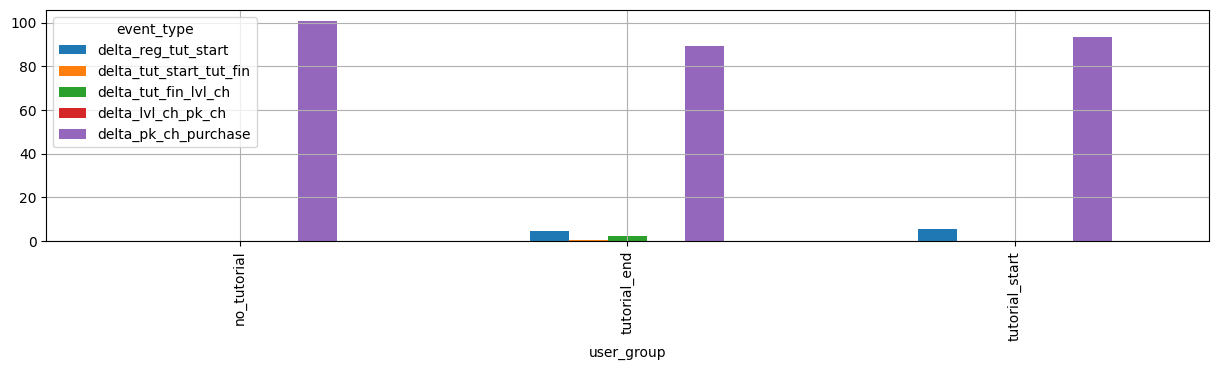

In [ ]:
# Hacemos un cronograma que muestre el tiempo medio que los grupos de usuarios gastaron para cada etapa del juego
group_time_events_df.plot(
    kind='bar',
    grid=True,
    figsize=(15, 3)
)

# Conclusion al cronogrma:

En el cronograma se ve que los usuarios que completaron el tutorial tardan menos tiempo en completar los tapas del juego.
Esos usuarios de media gastan menos tiempo de todos en hacer una compra, para se exactos 89.3 horas de media. Pero ellos gastan mas tiempo en la seleccion de preguntas, a diferencia de los usuarios que no han terminado el tutorial.\
Usuarios que no empezaron el tutorial gastan mas tiempo de todos en hacer una compra dentro del juego (100.83 horas de media)

# Comprobamos la hipotesis numero 2

Demostrar que la completacion del tutorial afecta positivamente las compras dentro del juego

In [ ]:
# Para empezar creamos la tabla dinamica en la cual escribiremos la cantidad de acciones hechos por usuarios
# De base usaremos la hoja Events.csv 
actions_df = events_df.pivot_table(
    values='start_time',
    index='user_id',
    columns='event_type',
    fill_value=0,
    aggfunc='count'
).reset_index()
display(actions_df.head())

event_type,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
0,27832,0,0,0,1,0,0
1,27833,0,0,0,1,1,1
2,27834,0,0,0,1,1,1
3,27835,1,1,0,1,1,1
4,27836,0,0,0,1,1,2


In [ ]:
# Borramos la columna event_type para que sea mas facil agrupar
actions_df.columns = ['user_id', 'level_choice', 'pack_choice', 'purchase', 'registration', 'tutorial_finish', 'tutorial_start']
display(actions_df.head())

,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
0,27832,0,0,0,1,0,0
1,27833,0,0,0,1,1,1
2,27834,0,0,0,1,1,1
3,27835,1,1,0,1,1,1
4,27836,0,0,0,1,1,2


In [ ]:
# Agrupamos a los usuarios en base de la cantidad de los registros y compras en el juego
tutorial_start = actions_df.groupby('tutorial_start')[['registration', 'purchase']].sum().reset_index()

# Añadimos la columna con el ratio de la cantidad de usuarios registrados y la cantidad de compras
tutorial_start['percent'] = round((tutorial_start['purchase'] / tutorial_start['registration']) * 100, 2)
display(tutorial_start)

,tutorial_start,registration,purchase,percent
0,0,8068,22,0.27
1,1,9103,1207,13.26
2,2,1589,218,13.72
3,3,427,51,11.94
4,4,221,30,13.57
5,5,109,16,14.68
6,6,116,14,12.07
7,7,94,12,12.77
8,8,86,13,15.12
9,9,113,17,15.04


In [ ]:
# Para mayor precision creamos una tabla parecida, pero con los usuarios que terminaron el tutorial
tutorial_finish = actions_df.groupby('tutorial_finish')[['registration', 'purchase']].sum().reset_index()
tutorial_finish['percent'] = round((tutorial_finish['purchase'] / tutorial_finish['registration']) * 100, 2)
display(tutorial_finish)

,tutorial_finish,registration,purchase,percent
0,0,9676,153,1.58
1,1,8015,1143,14.26
2,2,1321,182,13.78
3,3,345,44,12.75
4,4,178,19,10.67
5,5,117,19,16.24
6,6,101,15,14.85
7,7,97,15,15.46
8,8,54,6,11.11
9,9,22,4,18.18


Text(0.5, 1.0, 'Соотношение пользователей завершивших обучение к совершенным покупкам в игре')

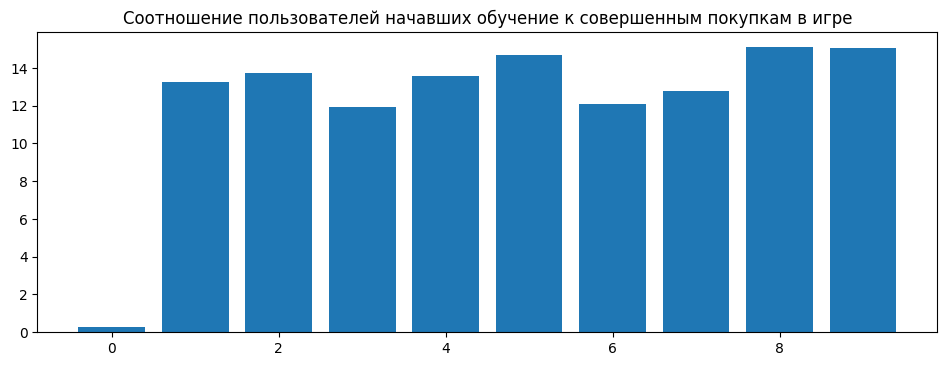

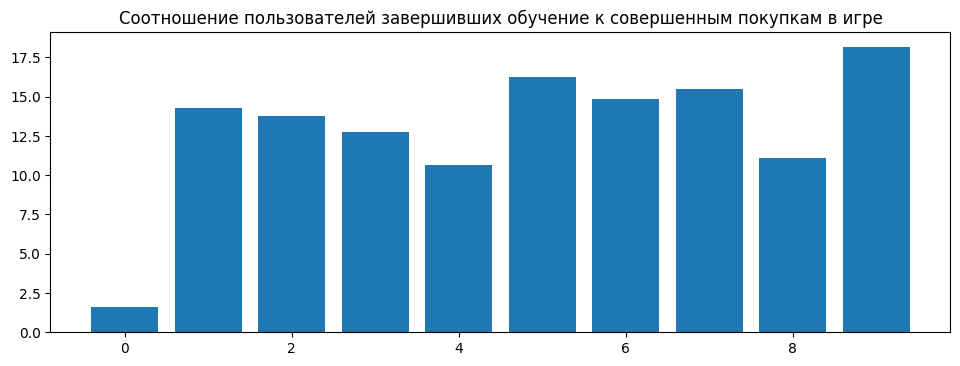

In [ ]:
# Creamos diagramas para los datos obtenidos
# Diagrama del ratio de usuarios que iniciaron el tutorial y las compras
fig = plt.figure(figsize=(9, 3))
axes = fig.add_axes([0, 0, 1, 1])
axes.bar(
    x=tutorial_start['tutorial_start'], 
    height=tutorial_start['percent']
)
axes.set_title('Соотношение пользователей начавших обучение к совершенным покупкам в игре')

# Diagrama del ratio de los usuarios que terminaron el tutorial y las compras
fig = plt.figure(figsize=(9, 3))
axes = fig.add_axes([0, 0, 1, 1])
axes.bar(
    x=tutorial_finish['tutorial_finish'], 
    height=tutorial_finish['percent']
)
axes.set_title('Соотношение пользователей завершивших обучение к совершенным покупкам в игре')

# Conclusiones a las diagramas obtenidas:

En los datos vemos que los usuarios que no han terminado el tutorial ni una vez hacen menos compras de todos, en cuanto los usuarios que completaron el tutorial al menos una vez hacen compras mas frequente. Ademas la mayoria de usuarios completan el tutorial 1 o 2 veces y sus ratios de completacion del tutorial y de compras son 14.26 y 13.78 por ciento respectivamente. En cuanto el mayor ratio de compras y completacion del tutorial lo tienen los usuarios que completaron el tutorial 9 veces (18.18 por ciento)

# Hipotesis numero 3

Comprobar, como de transparente es el proceso de interaccion con el juego.\
Tenemos que comprobar como de frequente los usuarios vuelven al tutorial despues de que eligieron el nivel de dificultad

In [ ]:
# Cramos una tabla en la qual para cada usuario escribiremos el tiempo de inicio de tutorial, 
# tiempo de eleccion de nivel de dificultad y la diferencia entre ellos
delta_start_level = pd.merge(
    events_df[events_df['event_type'] == 'level_choice'][[
    'user_id','start_time']].rename(columns= {'start_time':'level_choice_time'}), 
    events_df[events_df['event_type'] == 'tutorial_start'][[
    'user_id','start_time']].rename(columns= {'start_time':'tutorial_start_time'}), on='user_id')


# Calculamos la diferencia
delta_start_level['timedelta_start_choice'] = delta_start_level['tutorial_start_time'] - \
delta_start_level['level_choice_time']

display(delta_start_level.head())

,user_id,level_choice_time,tutorial_start_time,timedelta_start_choice
0,27835,2018-01-01 20:37:22,2018-01-01 15:00:51,-1 days +18:23:29
1,27839,2018-01-01 22:37:50,2018-01-01 19:11:36,-1 days +20:33:46
2,27840,2018-01-02 05:18:42,2018-01-02 02:07:07,-1 days +20:48:25
3,27845,2018-01-02 06:19:18,2018-01-02 03:03:44,-1 days +20:44:26
4,27845,2018-01-02 06:19:18,2018-01-02 07:08:00,0 days 00:48:42


In [24]:
# Ahora calculamos diferentes datos de cantidad de usuarios que completaron el tutorial despues de la eleccion de el nivel de dificultad
# y usuarios, que completaron el tutorial antes de la eleccion de el nivel de dificultad
users_choice_before_tutorial = delta_start_level.query(
    'timedelta_start_choice > "1 seconds"')['user_id'].nunique()
print('Пользователи, прошедшие обучение после выбора уровня сложности', users_choice_before_tutorial)

users_tutorial_before_choice = delta_start_level.query(
    'timedelta_start_choice < @pd.Timedelta(0)')['user_id'].nunique()
print('Пользователи, прошедшие обучение до выбора уровня сложности', users_tutorial_before_choice)

Пользователи, прошедшие обучение после выбора уровня сложности 1386
Пользователи, прошедшие обучение до выбора уровня сложности 8244


In [ ]:
# Para myor exactitud de datos, para cada usuario creamos una lista de todas las acciones que el usuario hizo en el juego
path_df = (
    events_df.groupby(["user_id"])["event_type"].apply(list).reset_index()
)

# Transformemos la lista de eventos en linea event_path
path_df["event_path"] = path_df["event_type"].apply(lambda x: " > ".join(x))

# Agrupamos el dataframe por la columna event_path, contando la cantida de usuarios
user_paths = (
    path_df.groupby(["event_path"])["user_id"]
    .nunique()
    .sort_values(ascending=False)
)

display(user_paths)

event_path
registration                                                                                                                                                                                                                                                                                                                                              7970
registration > tutorial_start > tutorial_finish > level_choice > pack_choice                                                                                                                                                                                                                                                                              2796
registration > tutorial_start > tutorial_finish                                                                                                                                                                                                                                                

In [ ]:
# Eligimos las rutas en la cuales primero va la eleccion de la dificultad y despues el tutorial

user_paths[user_paths.index.str.contains('level_choice > tutorial_start')]

event_path
registration > tutorial_start > tutorial_finish > level_choice > tutorial_start > tutorial_finish                                                                                                                                                                                                                                                         169
registration > tutorial_start > tutorial_finish > level_choice > tutorial_start                                                                                                                                                                                                                                                                            39
registration > tutorial_start > tutorial_finish > level_choice > tutorial_start > tutorial_finish > tutorial_start > tutorial_finish                                                                                                                                                             

In [ ]:
# Eligimos las rutas donde primero va la registarion y despues la eleccion de dificultad

user_paths[user_paths.index.str.contains('registration > level_choice > tutorial_start')]

Series([], Name: user_id, dtype: int64)

# Conclusiones a la hipotesis 3

Segun los datos obtenidos vemos, que 16.81 por ciento de usuarios vuelven al tutorial despues de eligir el nivel de dificultad. Tambien vemos que todos los usuarios que vuelven al tutorial despues de la eleccion de nivel de dificultad ya empezaban el tutorial al menos una vez. Eso dice de que para muchos usuarios el totorial no es suficiente informativo

# Conclusiones con el proyecto

# 1-a Hipotesis:
Segun los datos obtenidos vemos que el tiempo de completacion del juego para los usuarios que completaron el tutorial de media es menor.

# 2-a Hipotesis:
Segun los datos obtenidos vemos que los usuarios que completaron el tutorial al menos 1 vez hacen mas compras en el juego que los usuarios que no completaron el tutorial.

# 3-a Hipotesis:
Segun los datos obtenidos vemos que para muchos usuarios el tutorial es insuficiente informativo, por eso los usuarios vuelven al tutorial despues de eligir el nivel de dificultad.